# Prediction on Poor Performance Students

## Outline
- Part 0. Automation setup
- Part 1. Data preparation (create new aggregated features, subset the data by cutting out future data, convert categorical variable, split train and test data)
- Part 2. Model building (cross validation, parameter tuning)
- Part 3. Model evaluation (confusion matrix, KS statistics, cumulative gain chart)

# Part 0. Automation setup

- Select the metric to predict, the time to predict, the number of days to predict forward (for withdrawal), and algorithm
- Click on "run all below", the predictive model will be run automatically :)

In [4219]:
# Metric need to be predicted
metric = 'Fail' #'Withdrawn','Fail'
# Cut-off day
cutoff_i = 120
# For withdrawal only: number of days to predict forward
window_width = 7
# Algorithm
algorithm = 'Random Forest' #'Neural Network', 'XGBoost'

# Part 1. Data Preparation

## 1.1 Load package

In [4284]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import warnings
warnings.filterwarnings('ignore')

In [4285]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cross_validation import train_test_split
from xgboost import XGBClassifier

## 1.2 Read file

In [2185]:
course_student_all = pd.read_csv("~/Google Drive/MSBA@UMN/OULAD/course_student_all.csv")

In [2186]:
assessment_student_all = pd.read_csv("~/Google Drive/MSBA@UMN/OULAD/course_student_assessment.csv")

In [2187]:
vle_student_all = pd.read_csv("~/Google Drive/MSBA@UMN/OULAD/course_student_vle_final.csv")

## 1.3 Basic aggregation before joining

### 1) Course student table

In [4286]:
course_student_all.shape

(32446, 30)

In [4287]:
course_student_all.describe()

,Unnamed: 0,id_student,num_of_prev_attempts,studied_credits,date_registration,date_unregistration,module_presentation_length,Distinction,Fail,Pass,...,course_n_type,course_n_Exam,course_n_CMA,course_n_TMA,course_weight_total,course_weight_Exam,course_weight_CMA,course_weight_TMA,course_activity_n,course_site_n
count,32446.000000,3.244600e+04,32446.000000,32446.000000,32446.00000,10024.000000,32446.000000,32446.000000,32446.000000,32446.000000,...,32446.000000,32446.000000,32446.000000,32446.000000,32446.000000,32446.000000,32446.000000,32446.000000,32446.000000,32446.000000
mean,16223.500000,7.062130e+05,0.163163,79.671916,-69.42375,50.305866,255.988442,0.093201,0.216914,0.380941,...,2.664304,1.135548,3.819978,4.983141,205.754176,0.561595,0.020615,0.417790,11.020249,321.058312
std,9366.497754,5.486818e+05,0.479707,41.027368,49.27415,82.044471,13.182773,0.290718,0.412150,0.485626,...,0.472241,0.342314,2.885440,0.950003,45.853054,0.139548,0.035347,0.148151,2.649248,139.315641
min,1.000000,3.733000e+03,0.000000,30.000000,-322.00000,-317.000000,234.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,0.000000,3.000000,100.000000,0.500000,0.000000,0.000000,7.000000,106.000000
25%,8112.250000,5.084160e+05,0.000000,60.000000,-100.00000,-1.000000,241.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,0.000000,4.000000,200.000000,0.500000,0.000000,0.375000,10.000000,207.000000
50%,16223.500000,5.900790e+05,0.000000,60.000000,-57.00000,29.000000,262.000000,0.000000,0.000000,0.000000,...,3.000000,1.000000,5.000000,5.000000,200.000000,0.500000,0.000000,0.500000,10.000000,315.000000
75%,24334.750000,6.441362e+05,0.000000,120.000000,-29.00000,109.000000,268.000000,0.000000,0.000000,1.000000,...,3.000000,1.000000,7.000000,6.000000,200.000000,0.500000,0.025000,0.500000,11.000000,453.000000
max,32446.000000,2.698591e+06,6.000000,655.000000,167.00000,444.000000,269.000000,1.000000,1.000000,1.000000,...,3.000000,2.000000,7.000000,6.000000,300.000000,1.000000,0.125000,0.500000,16.000000,529.000000


#### Subset for cutting off point
- Remove those who registered after cut-off point
- Remove those who unregistered before cut-off point

In [4288]:
course_student_final = course_student_all[course_student_all['date_registration'] < cutoff_i]

In [4289]:
course_student_final = course_student_final\
[(course_student_final['date_unregistration'].isnull()) | (course_student_final['date_unregistration'] > cutoff_i-1)]

In [4290]:
course_student_final.shape

(24678, 30)

### 2) Assessment table

In [4291]:
assessment_student_all.shape

(173912, 25)

In [4292]:
assessment_student_all.describe()

,Unnamed: 0,id_assessment,id_student,date_submitted,is_banked,score,date,weight,CMA,Exam,...,course_n_assessment,course_n_Exam,course_n_CMA,course_n_TMA,number_of_assess,number_of_assess_r,number_of_assess_lag,score_lag,score_dif,total_score
count,173912.000000,173912.000000,1.739120e+05,173912.000000,173912.000000,173912.000000,173912.000000,173912.000000,173912.000000,173912.000000,...,173912.000000,173912.000000,173912.000000,173912.000000,173912.000000,173912.000000,173912.000000,148069.000000,148069.000000,173912.000000
mean,86956.500000,26553.803556,7.051507e+05,116.032942,0.010977,75.724171,132.727006,12.743899,0.405533,0.028514,...,10.770614,1.108906,4.608710,5.052998,4.921518,4.921518,3.921518,76.729511,-0.515550,9.088426
std,50204.214345,8829.784254,5.523952e+05,71.484148,0.104194,18.940093,79.110198,17.877301,0.490996,0.166438,...,2.680086,0.311522,2.672168,0.940125,3.146100,3.146100,3.146100,18.085162,19.450793,12.750937
min,1.000000,1752.000000,6.516000e+03,-11.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,0.000000,3.000000,1.000000,1.000000,0.000000,0.000000,-100.000000,0.000000
25%,43478.750000,15022.000000,5.044290e+05,51.000000,0.000000,65.000000,54.000000,0.000000,0.000000,0.000000,...,10.000000,1.000000,4.000000,5.000000,2.000000,2.000000,1.000000,67.000000,-11.000000,0.000000
50%,86956.500000,25359.000000,5.852080e+05,116.000000,0.000000,80.000000,131.000000,9.000000,0.000000,0.000000,...,12.000000,1.000000,5.000000,5.000000,4.000000,4.000000,3.000000,80.000000,0.000000,6.230000
75%,130434.250000,34883.000000,6.344980e+05,173.000000,0.000000,90.000000,222.000000,18.000000,1.000000,0.000000,...,13.000000,1.000000,7.000000,6.000000,7.000000,7.000000,6.000000,90.000000,10.000000,13.650000
max,173912.000000,37443.000000,2.698588e+06,608.000000,1.000000,100.000000,269.000000,100.000000,1.000000,1.000000,...,14.000000,2.000000,7.000000,6.000000,14.000000,14.000000,13.000000,100.000000,100.000000,100.000000


#### Subset for cutting off point
- Only keep the results happened before cut-off point

In [4293]:
assessment_student = assessment_student_all[assessment_student_all['date_submitted'] < cutoff_i]

#### Create the last score variables
- Last score before cut-off point

In [4294]:
assessment_student['number_of_assess_r'] = assessment_student.groupby(['code_module','code_presentation','id_student'])\
['date_submitted'].rank(ascending=False, method='first')

In [4295]:
last_score = assessment_student[assessment_student['number_of_assess_r'] == 1]

In [4296]:
last_score = last_score[['code_module','code_presentation','id_student','score','CMA','TMA','Exam']]

In [4297]:
last_score = last_score.rename(columns={'score': 'last_score', 'CMA': 'last_cma','TMA':'last_tma','Exam':'last_exam'})

#### Create aggregate attributes

In [4298]:
agg_assess = {'score': {'mean_score':'mean', 'sd_score': 'std', 'n_assess':'count'},\
              'score_dif':{'ma_score':'mean'},\
              'total_score': {'cum_total_score':'sum'},\
              'Exam': {'n_exam':'sum'},\
              'CMA': {'n_cma':'sum'},\
              'TMA': {'n_tma':'sum'},\
              'is_banked':{'is_banked':'mean'}}

In [4299]:
assessment_student_final = assessment_student.groupby(['code_module','code_presentation','id_student']).\
agg(agg_assess)

In [4300]:
assessment_student_final.columns = assessment_student_final.columns.droplevel()
assessment_student_final = assessment_student_final.reset_index() 

In [4301]:
# get the percentile for cumscore/meanscore
assessment_student_final['percentile_cum_score'] = assessment_student_final.\
groupby(['code_module','code_presentation'])['cum_total_score'].rank(pct = True)
assessment_student_final['percentile_mean_score'] = assessment_student_final.\
groupby(['code_module','code_presentation'])['mean_score'].rank(pct = True)

In [4302]:
# match last score
assessment_student_final = assessment_student_final.merge(last_score, how='left')

In [4303]:
assessment_student_final.shape

(25782, 18)

### 3) Interaction table

In [4304]:
vle_student_all.shape

(8459320, 18)

In [4305]:
vle_student_all.describe()

,Unnamed: 0,id_student,id_site,date,sum_click,week_from,week_to,course_activity_n,course_site_n,subpage_click,homepage_click,oucontent_click,forumng_click,resource_click,url_click
count,8.459320e+06,8.459320e+06,8.459320e+06,8.459320e+06,8.459320e+06,1.223593e+06,1.223593e+06,8.459320e+06,8.459320e+06,8.459320e+06,8.459320e+06,8.459320e+06,8.459320e+06,8.459320e+06,8.459320e+06
mean,4.229660e+06,7.332399e+05,7.351661e+05,9.393650e+01,4.066844e+00,1.053743e+01,1.056458e+01,1.196184e+01,3.649144e+02,4.032927e-01,8.214684e-01,1.248183e+00,5.744468e-01,1.262428e-01,6.699144e-02
std,2.441995e+06,5.846966e+05,1.307907e+05,7.598022e+01,9.756265e+00,8.373725e+00,8.352738e+00,2.826548e+00,1.412495e+02,1.733989e+00,3.838690e+00,5.660596e+00,2.288682e+00,3.015881e+00,4.029106e-01
min,1.000000e+00,6.516000e+03,5.267210e+05,-2.500000e+01,1.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,1.060000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.114831e+06,5.057670e+05,6.735190e+05,2.400000e+01,1.000000e+00,3.000000e+00,3.000000e+00,1.000000e+01,2.230000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.229660e+06,5.875500e+05,7.300350e+05,8.500000e+01,2.000000e+00,9.000000e+00,9.000000e+00,1.100000e+01,4.280000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,6.344490e+06,6.459970e+05,8.327600e+05,1.550000e+02,4.000000e+00,1.800000e+01,1.800000e+01,1.500000e+01,4.780000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,8.459320e+06,2.698588e+06,1.049562e+06,2.690000e+02,6.977000e+03,2.900000e+01,2.900000e+01,1.600000e+01,5.290000e+02,3.958000e+03,6.977000e+03,3.725000e+03,4.030000e+02,4.953000e+03,3.580000e+02


#### Subset for cutting off point
- Only keep the results happened before cut-off point

In [4306]:
vle_student = vle_student_all[vle_student_all['date'] < cutoff_i]

#### Create aggregate attributes

In [4307]:
agg_vle = {'date':{'total_active_day': 'nunique'},\
           'id_site': {'total_site':'count','total_uni_site': 'nunique'},\
           'subpage_click': {'total_visit_subpage':'count', 'total_click_subpage':'sum'},\
           'homepage_click': {'total_visit_homepage':'count', 'total_click_homepage':'sum'},\
           'oucontent_click': {'total_visit_oucontent':'count', 'total_click_oucontent':'sum'},\
           'forumng_click': {'total_visit_forumng':'count','total_click_forumng':'sum'},\
           'resource_click': {'total_visit_resource':'count', 'total_click_resource':'sum'},\
           'url_click': {'total_visit_url':'count', 'total_click_url':'sum'}} #'date':{'total_active_day': 'nunique'},\{'total_uni_site': 'nunique'}

In [4308]:
vle_student_final = vle_student.groupby(['code_module','code_presentation','id_student']).\
agg(agg_vle)

In [4309]:
vle_student_final.columns = vle_student_final.columns.droplevel()
vle_student_final = vle_student_final.reset_index() 

In [4310]:
vle_student_final.shape

(29195, 18)

## 1.4 Select variables for independent variables

### Drop variables - used to fine-tune variables easily

In [4311]:
assessment_student_final.columns

Index([u'code_module', u'code_presentation', u'id_student', u'n_exam',
       u'cum_total_score', u'is_banked', u'n_cma', u'n_tma', u'mean_score',
       u'sd_score', u'n_assess', u'ma_score', u'percentile_cum_score',
       u'percentile_mean_score', u'last_score', u'last_cma', u'last_tma',
       u'last_exam'],
      dtype='object')

In [4312]:
assessment_student_final = assessment_student_final.\
drop(['sd_score','ma_score',\
      'last_exam','n_cma', 'n_tma','n_exam','mean_score','cum_total_score'], axis=1)

In [4313]:
vle_student_final.columns

Index([u'code_module', u'code_presentation', u'id_student', u'total_uni_site',
       u'total_site', u'total_click_forumng', u'total_visit_forumng',
       u'total_click_url', u'total_visit_url', u'total_click_resource',
       u'total_visit_resource', u'total_active_day', u'total_click_subpage',
       u'total_visit_subpage', u'total_click_oucontent',
       u'total_visit_oucontent', u'total_visit_homepage',
       u'total_click_homepage'],
      dtype='object')

In [4314]:
#vle_student_final = vle_student_final.\
#drop(['mean_click_forumng','mean_click_resource','mean_click_url',\
#      'mean_click_subpage','mean_click_oucontent','mean_click_homepage'], axis=1)

In [4315]:
course_student_final.columns

Index([u'Unnamed: 0', u'code_module', u'code_presentation', u'id_student',
       u'gender', u'region', u'highest_education', u'imd_band', u'age_band',
       u'num_of_prev_attempts', u'studied_credits', u'disability',
       u'final_result', u'date_registration', u'date_unregistration',
       u'module_presentation_length', u'Distinction', u'Fail', u'Pass',
       u'Withdrawn', u'course_n_type', u'course_n_Exam', u'course_n_CMA',
       u'course_n_TMA', u'course_weight_total', u'course_weight_Exam',
       u'course_weight_CMA', u'course_weight_TMA', u'course_activity_n',
       u'course_site_n'],
      dtype='object')

In [4316]:
course_student_final = course_student_final.\
drop(['Unnamed: 0','region','final_result','module_presentation_length','Distinction',\
     'Pass','Withdrawn', u'course_n_type', u'course_weight_total', u'course_weight_Exam',
       u'course_weight_CMA', u'course_weight_TMA', u'course_activity_n',
       u'course_site_n'], axis=1)
#must keep 3 PK and 2 date
if (metric == 'Withdrawn'):
    course_student_final = course_student_final.drop(['Fail'], axis=1)

### Merge all tables together

In [4317]:
dataset = course_student_final.merge(vle_student_final, how='left', on=['code_module', 'code_presentation','id_student'])

In [4318]:
dataset = dataset.merge(assessment_student_final, how='left', on=['code_module', 'code_presentation','id_student'])

In [4319]:
dataset['p_assess'] = dataset['n_assess']/ (dataset['course_n_Exam'] + dataset['course_n_CMA'] + dataset['course_n_TMA'])

In [4320]:
dataset = dataset.drop(['n_assess','course_n_Exam','course_n_CMA','course_n_TMA'], axis=1)

In [4321]:
dataset.shape

(24678, 35)

### Convert categorical data into dummy variables
- Here I've tried both one-hot encoding for all categorical variables, and converted some categorical variables into numeric when the relationship is ordinal (like age, region level and education)
- The results do not differ much. In reality, tree-based model is better to handle numeric variables than many categorical one, especially if the tree is shallow, categorical variables are less likely to be used up
- Reference: https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931

In [4322]:
cleanup_nums = {"age_band":     {"0-35": 1, "35-55": 2, "55<=": 3},
                "imd_band": {"0-10%": 1, "10-20": 2, "20-30%": 3, "30-40%": 4,"40-50%": 5,
                                  "50-60%": 6, "60-70%": 7, "70-80%":8, "80-90%":9, "90-100%":10 },
                "highest_education": {"No Formal quals": 1, "Lower Than A Level": 2, 
                                      "HE Qualification": 3, "A Level or Equivalent": 4,"Post Graduate Qualification": 5}}

In [4323]:
dataset.replace(cleanup_nums, inplace=True)

In [4324]:
cols_to_transform = ['code_module','code_presentation','gender','disability'] #'code_module','code_presentation',\

In [4325]:
dataset_final = pd.get_dummies(dataset, columns = cols_to_transform, drop_first=True)


### For withdrawal case, adjust the window

In [4326]:
if (metric == 'Withdrawn') & (cutoff_i <30):
    dataset_final['Withdrawn'] = np.where((dataset_final['date_unregistration'] < cutoff_i + window_width + 1), 1, 0)
elif (metric == 'Withdrawn') & (cutoff_i >= 30):
    dataset_final['Withdrawn'] = np.where((dataset_final['date_unregistration'] < cutoff_i + 30 + 1), 1, 0)

In [4327]:
dataset_final = dataset_final.fillna(0) #fill in all missing values with 0

## 1.5 Split train and test
- As I don't put the historical data (i.e. the information happen in previous term), the train test split is purly random, rather than leaving out results in 2014J.

In [4328]:
X = dataset_final.drop([metric,'date_unregistration','id_student'], axis=1)
y = dataset_final[metric]

In [4329]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.3, random_state=20)

In [4330]:
X_train.shape, X_test.shape

((17274, 39), (7404, 39))

In [4331]:
y_train.shape, y_test.shape

((17274,), (7404,))

In [4332]:
np.mean(y_train), np.mean(y_test) #label % in two groups, for QC

(0.28291073289336577, 0.29038357644516477)

In [4333]:
X_train.columns #final labels, for QC

Index([u'highest_education', u'imd_band', u'age_band', u'num_of_prev_attempts',
       u'studied_credits', u'date_registration', u'total_uni_site',
       u'total_site', u'total_click_forumng', u'total_visit_forumng',
       u'total_click_url', u'total_visit_url', u'total_click_resource',
       u'total_visit_resource', u'total_active_day', u'total_click_subpage',
       u'total_visit_subpage', u'total_click_oucontent',
       u'total_visit_oucontent', u'total_visit_homepage',
       u'total_click_homepage', u'is_banked', u'percentile_cum_score',
       u'percentile_mean_score', u'last_score', u'last_cma', u'last_tma',
       u'p_assess', u'code_module_BBB', u'code_module_CCC', u'code_module_DDD',
       u'code_module_EEE', u'code_module_FFF', u'code_module_GGG',
       u'code_presentation_2013J', u'code_presentation_2014B',
       u'code_presentation_2014J', u'gender_M', u'disability_Y'],
      dtype='object')

# Part 2. Model Building

### 2.1 Random Forest

In [4334]:
if algorithm == "Random Forest":
    rf = RandomForestClassifier(random_state=12345)
    rf_grid = {'n_estimators':[60, 80],'max_depth':[8,10], 'max_features':[8,12]} #, 'max_features':[10,20] 

    rf_cv = GridSearchCV(estimator=rf, param_grid=rf_grid, cv=5, scoring='f1') 
    rf_final = rf_cv.fit(X_train, y_train)

    y_pred = rf_final.predict(X_test)
    y_pred_p = rf_final.predict_proba(X_test)
    print rf_cv.best_params_

{'max_features': 12, 'n_estimators': 60, 'max_depth': 10}


### 2.2 XGBoost
- XGBoost has similar performance as random forest. Considering the calculation speed, random forest will be used as final model

In [4335]:
if algorithm == "XGBoost":
    reg = XGBClassifier(seed=12345,silent=0)
    reg_pram = {'n_estimators':[80,100],'learning_rate':[0.01, 0.1],'subsample':[0.6,0.8]}
    reg_search = GridSearchCV(reg, reg_pram, cv = 5, scoring='f1')
    reg_final = reg_search.fit(X_train, y_train)
    y_pred = reg_final.predict(X_test)
    y_pred_p = reg_final.predict_proba(X_test)

### 2.3 Neural Network
- Neural network provides slightly better performance. However as it is a black box model that cannot provide the feature importance, I didn't use it for final model

In [4336]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical

In [4337]:
if algorithm == "Neural Network":
    # Save the number of columns in predictors: n_cols
    n_cols = X_train.shape[1]
    input_shape = (n_cols,)

    # Specify the model
    model = Sequential()
    model.add(Dense(60, activation='relu', input_shape = input_shape))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',loss = 'binary_crossentropy', metrics=['accuracy'])

    # Define early_stopping_monitor
    #early_stopping_monitor = EarlyStopping(patience=2) #generally it's 2 to 3

    # Fit the model
    model.fit(X_train.values,y_train.values,epochs=30,validation_split=0.3) #,callbacks = [early_stopping_monitor]
    y_pred = model.predict_proba(X_test.values)

### 2.4 Feature importance (from random forest)

In [4338]:
if algorithm == "Random Forest":
    feature_importance_rf = dict(zip(X_train.columns,rf_final.best_estimator_.feature_importances_*100))
    print sorted([(value,key) for (key,value) in feature_importance_rf.items()])

[(0.12768055398519079, 'code_module_EEE'), (0.13242089451797037, 'last_cma'), (0.16397364033273154, 'last_tma'), (0.17765229890893758, 'code_module_GGG'), (0.22950769546844765, 'code_presentation_2013J'), (0.23080081209713607, 'disability_Y'), (0.25108981315430184, 'is_banked'), (0.26316748997087397, 'gender_M'), (0.26469427893978836, 'code_module_CCC'), (0.26839110553081075, 'code_module_BBB'), (0.28052025190572827, 'age_band'), (0.33775926234515596, 'code_presentation_2014B'), (0.35244683514708364, 'code_module_FFF'), (0.36474460939544817, 'code_presentation_2014J'), (0.45738173355867423, 'code_module_DDD'), (0.48698550638994448, 'num_of_prev_attempts'), (0.81636217750358286, 'highest_education'), (0.98982739657616403, 'total_visit_resource'), (1.0960138075899861, 'total_visit_homepage'), (1.119061054183776, 'studied_credits'), (1.1435419147415911, 'total_visit_oucontent'), (1.2295632063574149, 'total_visit_subpage'), (1.2801649789594396, 'total_visit_forumng'), (1.3766491702456725, 

# Part 3. Model Evaluation

### 3.1 Basic model performance
- Here the basic performance is printed for easily refer. However for our case, cutting off the positive case at probability 0.5 (by default setting in classification problem) is not helpful for targeting. Thus I will use KS statistic to evaluate performance, and cumulative gain chart to show the % of positive cases among those who are targeted.

In [4339]:
print 'Accuracy of model:', accuracy_score(y_test, y_pred)
print 'Classification report of model:'
print classification_report(y_test, y_pred)
print 'Confusion matrix'
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print (tn, fp, fn, tp) 

Accuracy of model: 0.811993517018
Classification report of model:
             precision    recall  f1-score   support

          0       0.83      0.93      0.87      5254
          1       0.75      0.53      0.62      2150

avg / total       0.81      0.81      0.80      7404

Confusion matrix
(4865, 389, 1003, 1147)


###  3.2 KS statistics
- K-S is a measure of the degree of separation between the positive and negative distributions. The K-S is 100, if the scores partition the population into two separate groups in which one group contains all the positives and the other all the negatives.
- Reference: https://www.analyticsvidhya.com/blog/2016/02/7-important-model-evaluation-error-metrics/

In [4340]:
import matplotlib.pyplot as plt
import scikitplot as skplt

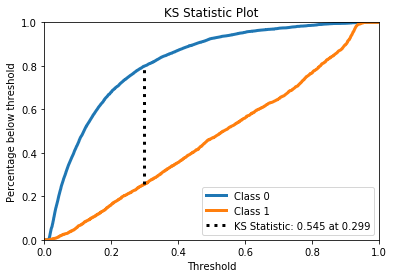

In [4341]:
skplt.metrics.plot_ks_statistic(y_test, y_pred_p)
plt.show()

### 3.3 Cumulative gain charts
- Gain chart shows that for different % of targeted samples, what is the % of positive cases among all samples targeted
- Reference: http://mlwiki.org/index.php/Cumulative_Gain_Chart

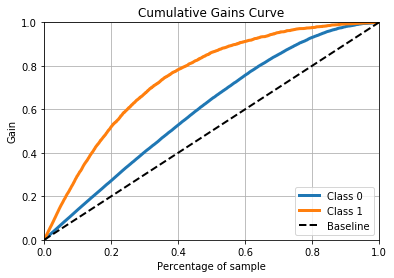

In [4342]:
skplt.metrics.plot_cumulative_gain(y_test, y_pred_p)
plt.show()

In [4343]:
#skplt.estimators.plot_learning_curve(rf_final.best_estimator_, X_train, y_train)
#plt.show()

#### Getting the data for charting...
- Reference: https://github.com/reiinakano/scikit-plot/blob/master/scikitplot/helpers.py
- Here I get the gain calculation directly from the code source from scikitplot package

In [4344]:
def cumulative_gain_curve(y_true, y_score, pos_label=None):
    y_true, y_score = np.asarray(y_true), np.asarray(y_score)

    # ensure binary classification if pos_label is not specified
    classes = np.unique(y_true)
    if (pos_label is None and
        not (np.array_equal(classes, [0, 1]) or
             np.array_equal(classes, [-1, 1]) or
             np.array_equal(classes, [0]) or
             np.array_equal(classes, [-1]) or
             np.array_equal(classes, [1]))):
        raise ValueError("Data is not binary and pos_label is not specified")
    elif pos_label is None:
        pos_label = 1.

    # make y_true a boolean vector
    y_true = (y_true == pos_label)

    sorted_indices = np.argsort(y_score)[::-1]
    y_true = y_true[sorted_indices]
    gains = np.cumsum(y_true)

    percentages = np.arange(start=1, stop=len(y_true) + 1)

    gains = gains / float(np.sum(y_true))
    percentages = percentages / float(len(y_true))

    gains = np.insert(gains, 0, [0])
    percentages = np.insert(percentages, 0, [0])

    return percentages, gains

In [4345]:
percentages, gains = cumulative_gain_curve(y_test, y_pred_p[:, 1])

In [4346]:
gain_result = DataFrame(gains)

In [4347]:
percentages_result = DataFrame(percentages)

In [4348]:
final_metric = pd.concat([percentages_result, gain_result], axis=1)

In [4349]:
#final_metric.to_csv("~/Google Drive/MSBA@UMN/OULAD/cumulative_gain_withdraw.csv")